# Import

## Modules

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from datetime import timedelta
import arviz as az
from sklearn.model_selection import train_test_split


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
sns.set_palette("deep")

 Setup path

In [3]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [4]:
from src.data.make_dataset import get_cases_data, to_datetime, subset_latest_outbreak, get_daily_cases_stats

## Data

In [5]:
raw_cases_data = get_cases_data()

## Audit

In [6]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9372 entries, 0 to 9371
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   notification_date           9372 non-null   object 
 1   postcode                    8575 non-null   object 
 2   likely_source_of_infection  9372 non-null   object 
 3   lhd_2010_code               8565 non-null   object 
 4   lhd_2010_name               8565 non-null   object 
 5   lga_code19                  8565 non-null   float64
 6   lga_name19                  8565 non-null   object 
dtypes: float64(1), object(6)
memory usage: 512.7+ KB


In [7]:
raw_cases_data.head()

,notification_date,postcode,likely_source_of_infection,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,Overseas,X700,Sydney,11300.0,Burwood (A)
1,2020-01-25,2121,Overseas,X760,Northern Sydney,16260.0,Parramatta (C)
2,2020-01-25,2071,Overseas,X760,Northern Sydney,14500.0,Ku-ring-gai (A)
3,2020-01-27,2033,Overseas,X720,South Eastern Sydney,16550.0,Randwick (C)
4,2020-03-01,2077,Overseas,X760,Northern Sydney,14000.0,Hornsby (A)


# Preprocess data

In [8]:
raw_cases_data = to_datetime('notification_date', raw_cases_data)
data = subset_latest_outbreak('2021-06-01', 'Overseas', raw_cases_data)

In [9]:
data = get_daily_cases_stats(data)

In [10]:
mask = data['Epidemiological Days'] == 0
initial_number_of_cases = data.loc[mask, 'Weekly Rolling Average'].values[0]
print(f"Initial number of cases: {initial_number_of_cases}")

mask = data['Epidemiological Days'] >= 0
X = data.loc[mask, ["Epidemiological Days", 'Daily Number of Cases', 'Growth Factor']]
y = data.loc[mask, "Weekly Rolling Average"]

Initial number of cases: 105.42857142857143


# Model Training

## Data Preparation

In [11]:
train_size = 0.7
X_train = X.head(round(len(X)*train_size))
X_test = X.tail(round(len(X)*(1-train_size)))
y_train = y.head(round(len(X)*train_size))
y_test = y.tail(round(len(X)*(1-train_size)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

daily_number_of_cases_std = X_train['Daily Number of Cases'].std()
average_growth_factor = X_train['Growth Factor'].mean()
std_growth_factor = X_train['Growth Factor'].std()

X_train = X_train["Epidemiological Days"].values
y_train = y_train.values
X_test = X_test["Epidemiological Days"].values
y_test = y_test.values

X = X["Epidemiological Days"].values
y = y.values

## Training

In [12]:
# Create PyMC3 context manager
with pm.Model() as model:
    t = pm.Data("X", X_train)
    cases = pm.Data("y", y_train)

    # Intercept - We fixed this at 100.
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope - Growth rate: 0.2 is approx value reported by others
    b = pm.Normal("b", mu=average_growth_factor, sigma=std_growth_factor)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)
    # pm.Poisson("cases", mu=growth, observed=cases)

    trace = pm.sample(1000, tune=1000, cores=5, return_inferencedata=True)
    post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, b, a]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 14 seconds.


## Model Evaluation

In [13]:
# Update data reference.
pm.set_data({"X": X_test}, model=model)

# Generate posterior samples
post_pred_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)


/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [14]:
def point_set_distance(y_pred, y_std, y):
    """
    Compute the point-to-set distance between the predicted and true values.

    Parameters:
    ----------- 
    y_pred: Numpy array. Predicted value. 
    y_std: Numpy array. Standard deviation of the predicted value.
    y: Numpy array. True value.

    Returns:
    --------
    point-to-set distance: Numpy array. Hausdorff distance between the predicted and true values.
    """
    assert y_pred.shape == y.shape, "The shapes of the predicted and true values do not match."
    assert y_pred.shape == y_std.shape, "The shapes of predicted and std values do not match."

    d = []
    for i in range(y_pred.shape[0]):
        if y_pred[i] - y_std[i] <= y[i] <= y_pred[i] + y_std[i]:
            d.append(0)
        
        else:
            d.append(min(abs(y[i] - (y_pred[i] + y_std[i]))
                        ,abs(y[i] - (y_pred[i] - y_std[i])))
                    )

    return np.array(d)

In [15]:
# References
# ----------[1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t

y_pred = np.mean(post_pred_test["cases"].T, axis=1)
y_std = np.std(post_pred_test["cases"].T, axis=1)

sst = np.var(y)
ssr = np.sum((point_set_distance(y_pred, y_std, y_test))**2)
r2 = 1 - (ssr/sst)

rmse = np.sqrt((point_set_distance(y_pred, y_std, y_test)**2).mean())
rmsre = np.sqrt((point_set_distance(y_pred, y_std, y_test)**2 / y_test**2).mean()) # Root Mean Squared Relative Error [%]
rrmse = np.sqrt((point_set_distance(y_pred, y_std, y_test)**2).mean() / (y_test**2).sum()) # Root Relative Mean Squared Error
mae = abs(point_set_distance(y_pred, y_std, y_test)).mean()
rmae = abs(point_set_distance(y_pred, y_std, y_test) / y_test).mean()
print(f"R2 = {r2}")
print(f"RMSE = {rmse}, RMSRE = {rmsre}, RRMSE = {rrmse}")
print(f"MAE = {mae}, Relative MAE = {rmae}")

R2 = 0.954139177578084
RMSE = 3.708601066549751, RMSRE = 0.04143514760447536, RRMSE = 0.00989291341883246
MAE = 1.4733555400264193, Relative MAE = 0.017048737836852554


/home/vscode/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


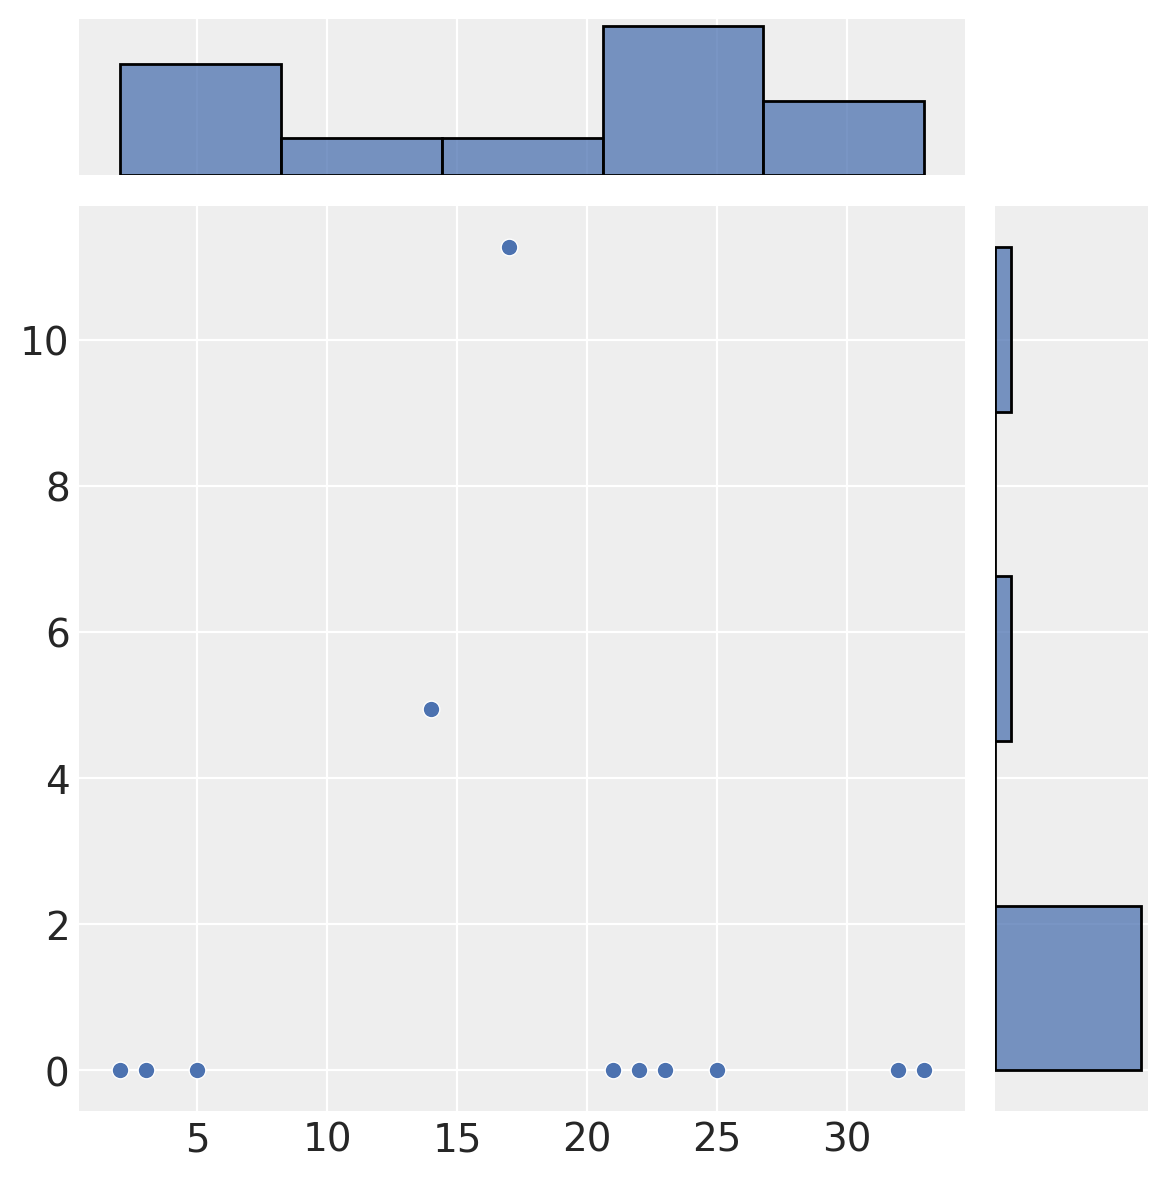

In [16]:
sns.jointplot(x=X_test, y=point_set_distance(y_pred, y_std, y_test), marker="o")

# Model Inference

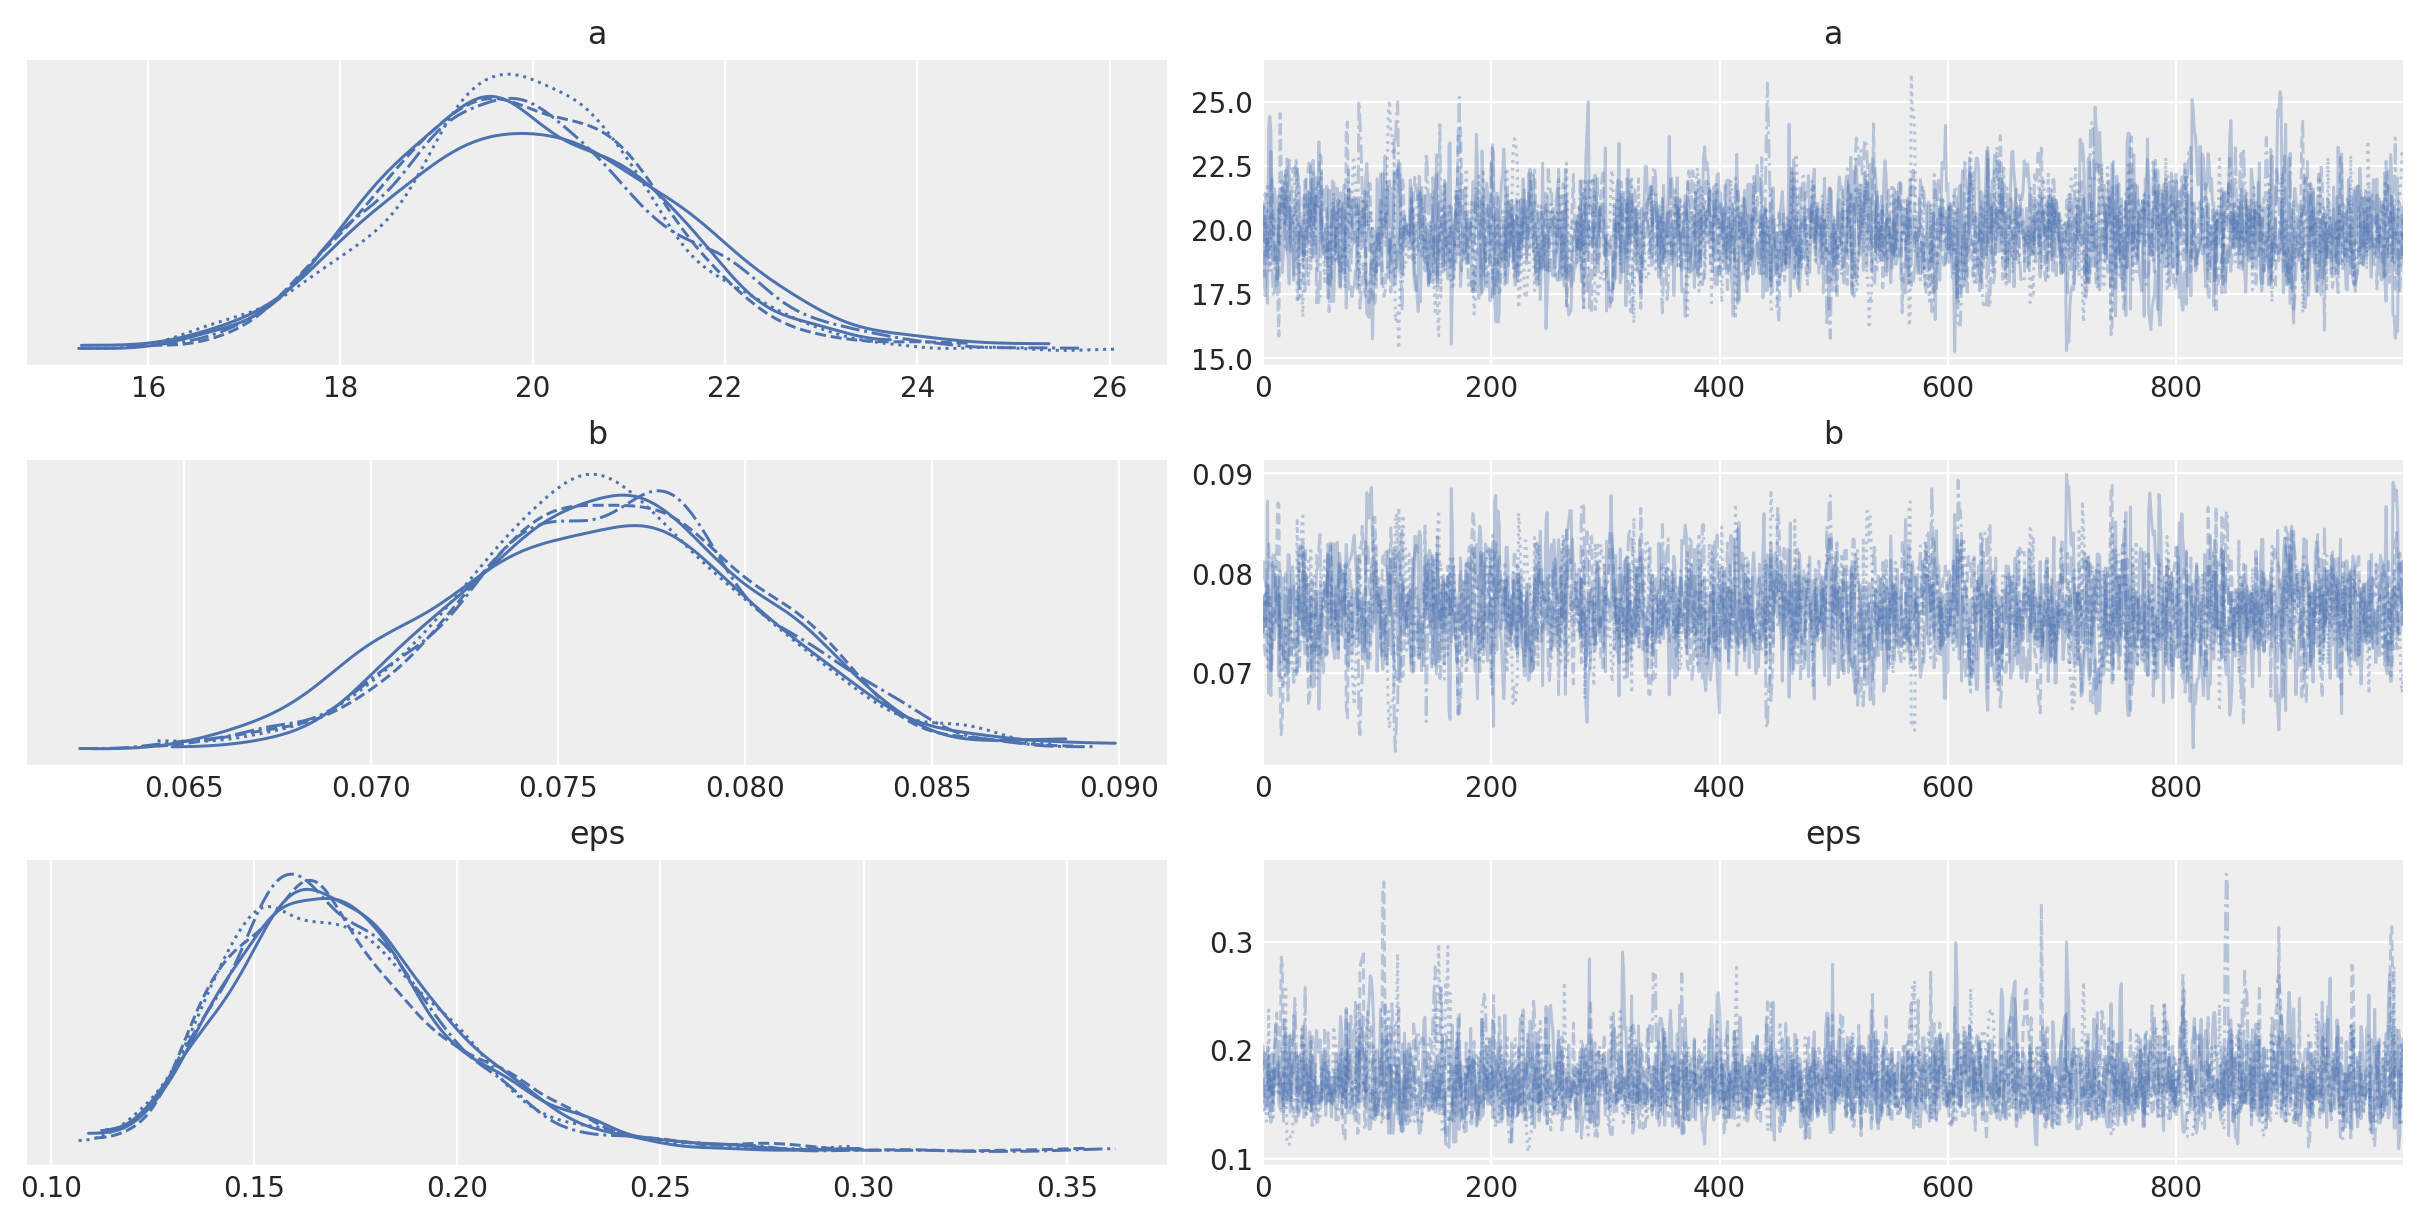

In [17]:
az.plot_trace(trace)
plt.show()

In [18]:
pm.summary(trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,19.909,1.453,17.375,22.805,0.035,0.025,1740.0,2000.0,1.01
b,0.076,0.004,0.069,0.084,0.000,0.000,1704.0,2003.0,1.00
eps,0.172,0.029,0.122,0.224,0.001,0.000,2187.0,2245.0,1.00


In [19]:
# Update data reference.
pm.set_data({"X": X}, model=model)

# Generate posterior samples
post_pred = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


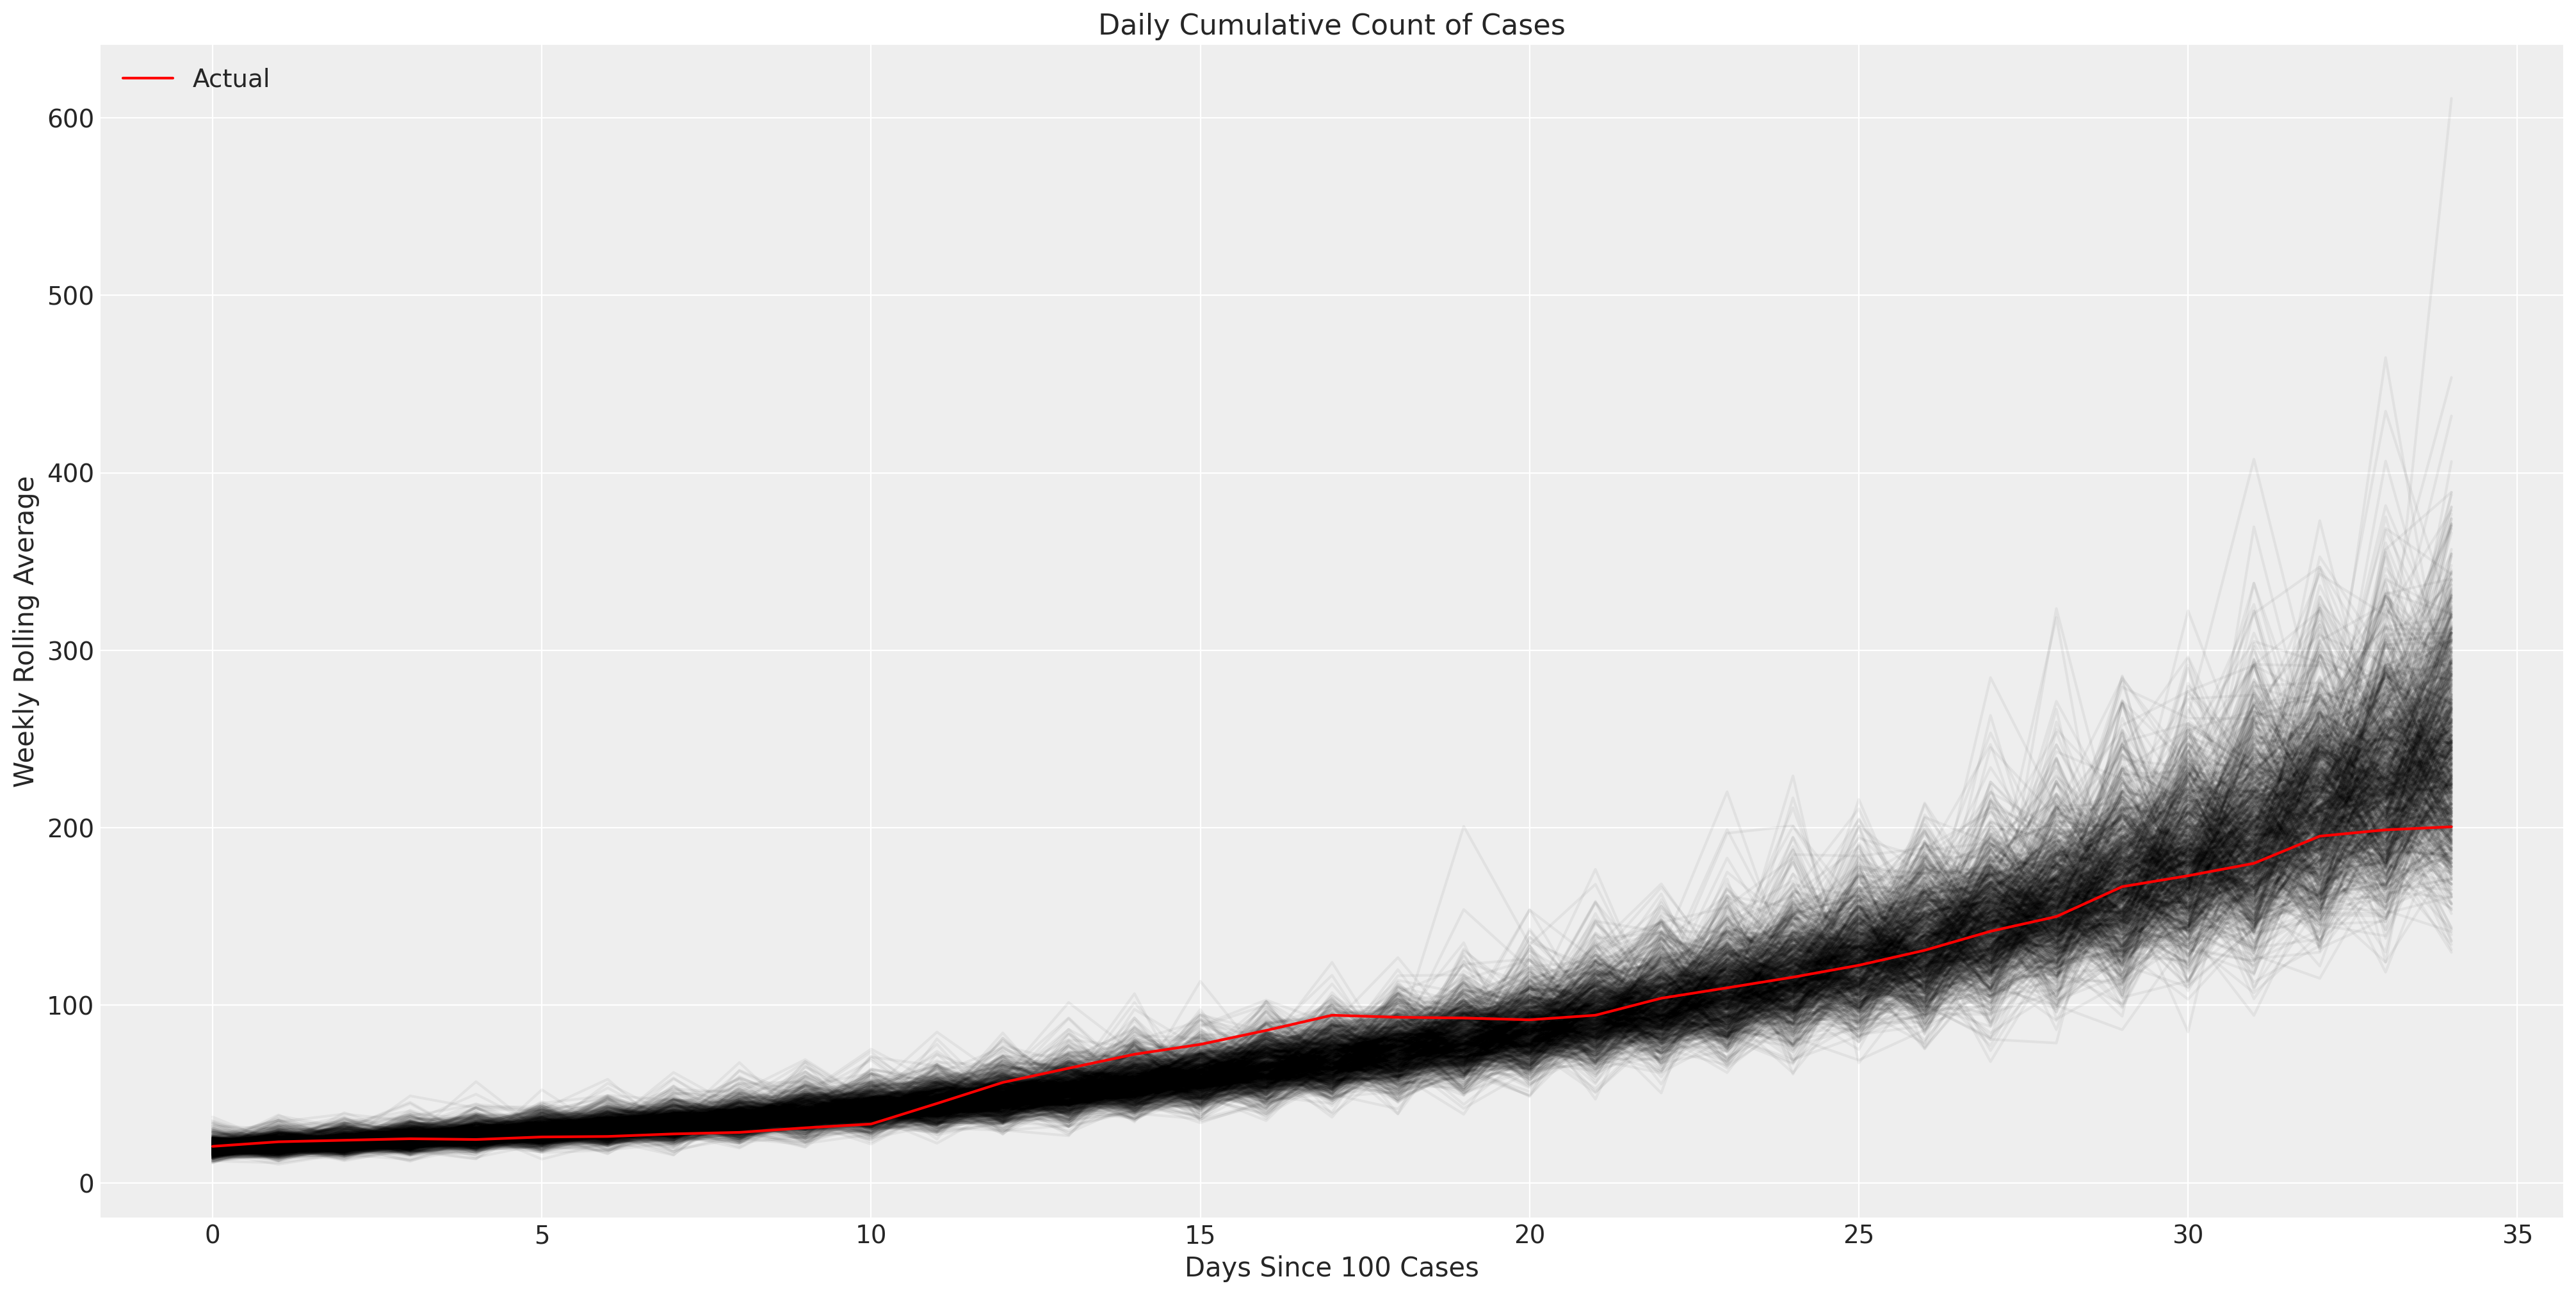

In [20]:
mask = data['Epidemiological Days'] >= 0

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X, post_pred["cases"].T, color="k", alpha=0.05)
ax.plot(X, data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
# ax.set_yscale("log")
ax.set(xlabel="Days Since 100 Cases", ylabel="Weekly Rolling Average", title="Daily Cumulative Count of Cases")
ax.legend()
# plt.show()

# Forecast Seven Days Ahead

In [21]:
forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max(), X.max() + forecast_ndays)))

# Update data reference.
pm.set_data({"X": X_forecast}, model=model)
# Generate posterior samples.
post_pred_forecast = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [22]:
mask = data["Epidemiological Days"] >= 0
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast
                            ,"Predicted Weekly Rolling Average": np.mean(post_pred_forecast["cases"].T, axis=1)
                            ,"notification_date": data.loc[mask, "notification_date"].append(pd.Series([data["notification_date"].max() + timedelta(days=day) for day in range(forecast_ndays)]))
                            ,"Predicted Weekly Rolling Std": np.std(post_pred_forecast["cases"].T, axis=1)
                            })
data_forecast.reset_index(inplace=True, drop=True)
data_forecast["Prediction Lower Bound"] = data_forecast["Predicted Weekly Rolling Average"] - data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Prediction Upper Bound"] = data_forecast["Predicted Weekly Rolling Average"] + data_forecast["Predicted Weekly Rolling Std"]
data_forecast

,Epidemiological Days,Predicted Weekly Rolling Average,notification_date,Predicted Weekly Rolling Std,Prediction Lower Bound,Prediction Upper Bound
0,0.0,20.132182,2021-06-29,3.867807,16.264374,23.999989
1,1.0,21.648856,2021-06-30,4.195445,17.453411,25.844301
2,2.0,23.430764,2021-07-01,4.449584,18.981180,27.880348
3,3.0,25.119151,2021-07-02,4.709230,20.409921,29.828381
4,4.0,26.888284,2021-07-03,4.869106,22.019177,31.757390
5,5.0,29.063078,2021-07-04,5.584165,23.478913,34.647242
6,6.0,31.219580,2021-07-05,5.727032,25.492548,36.946612
7,7.0,33.743474,2021-07-06,6.216700,27.526775,39.960174
8,8.0,36.267703,2021-07-07,7.030809,29.236894,43.298512
9,9.0,39.120498,2021-07-08,7.005063,32.115435,46.125561


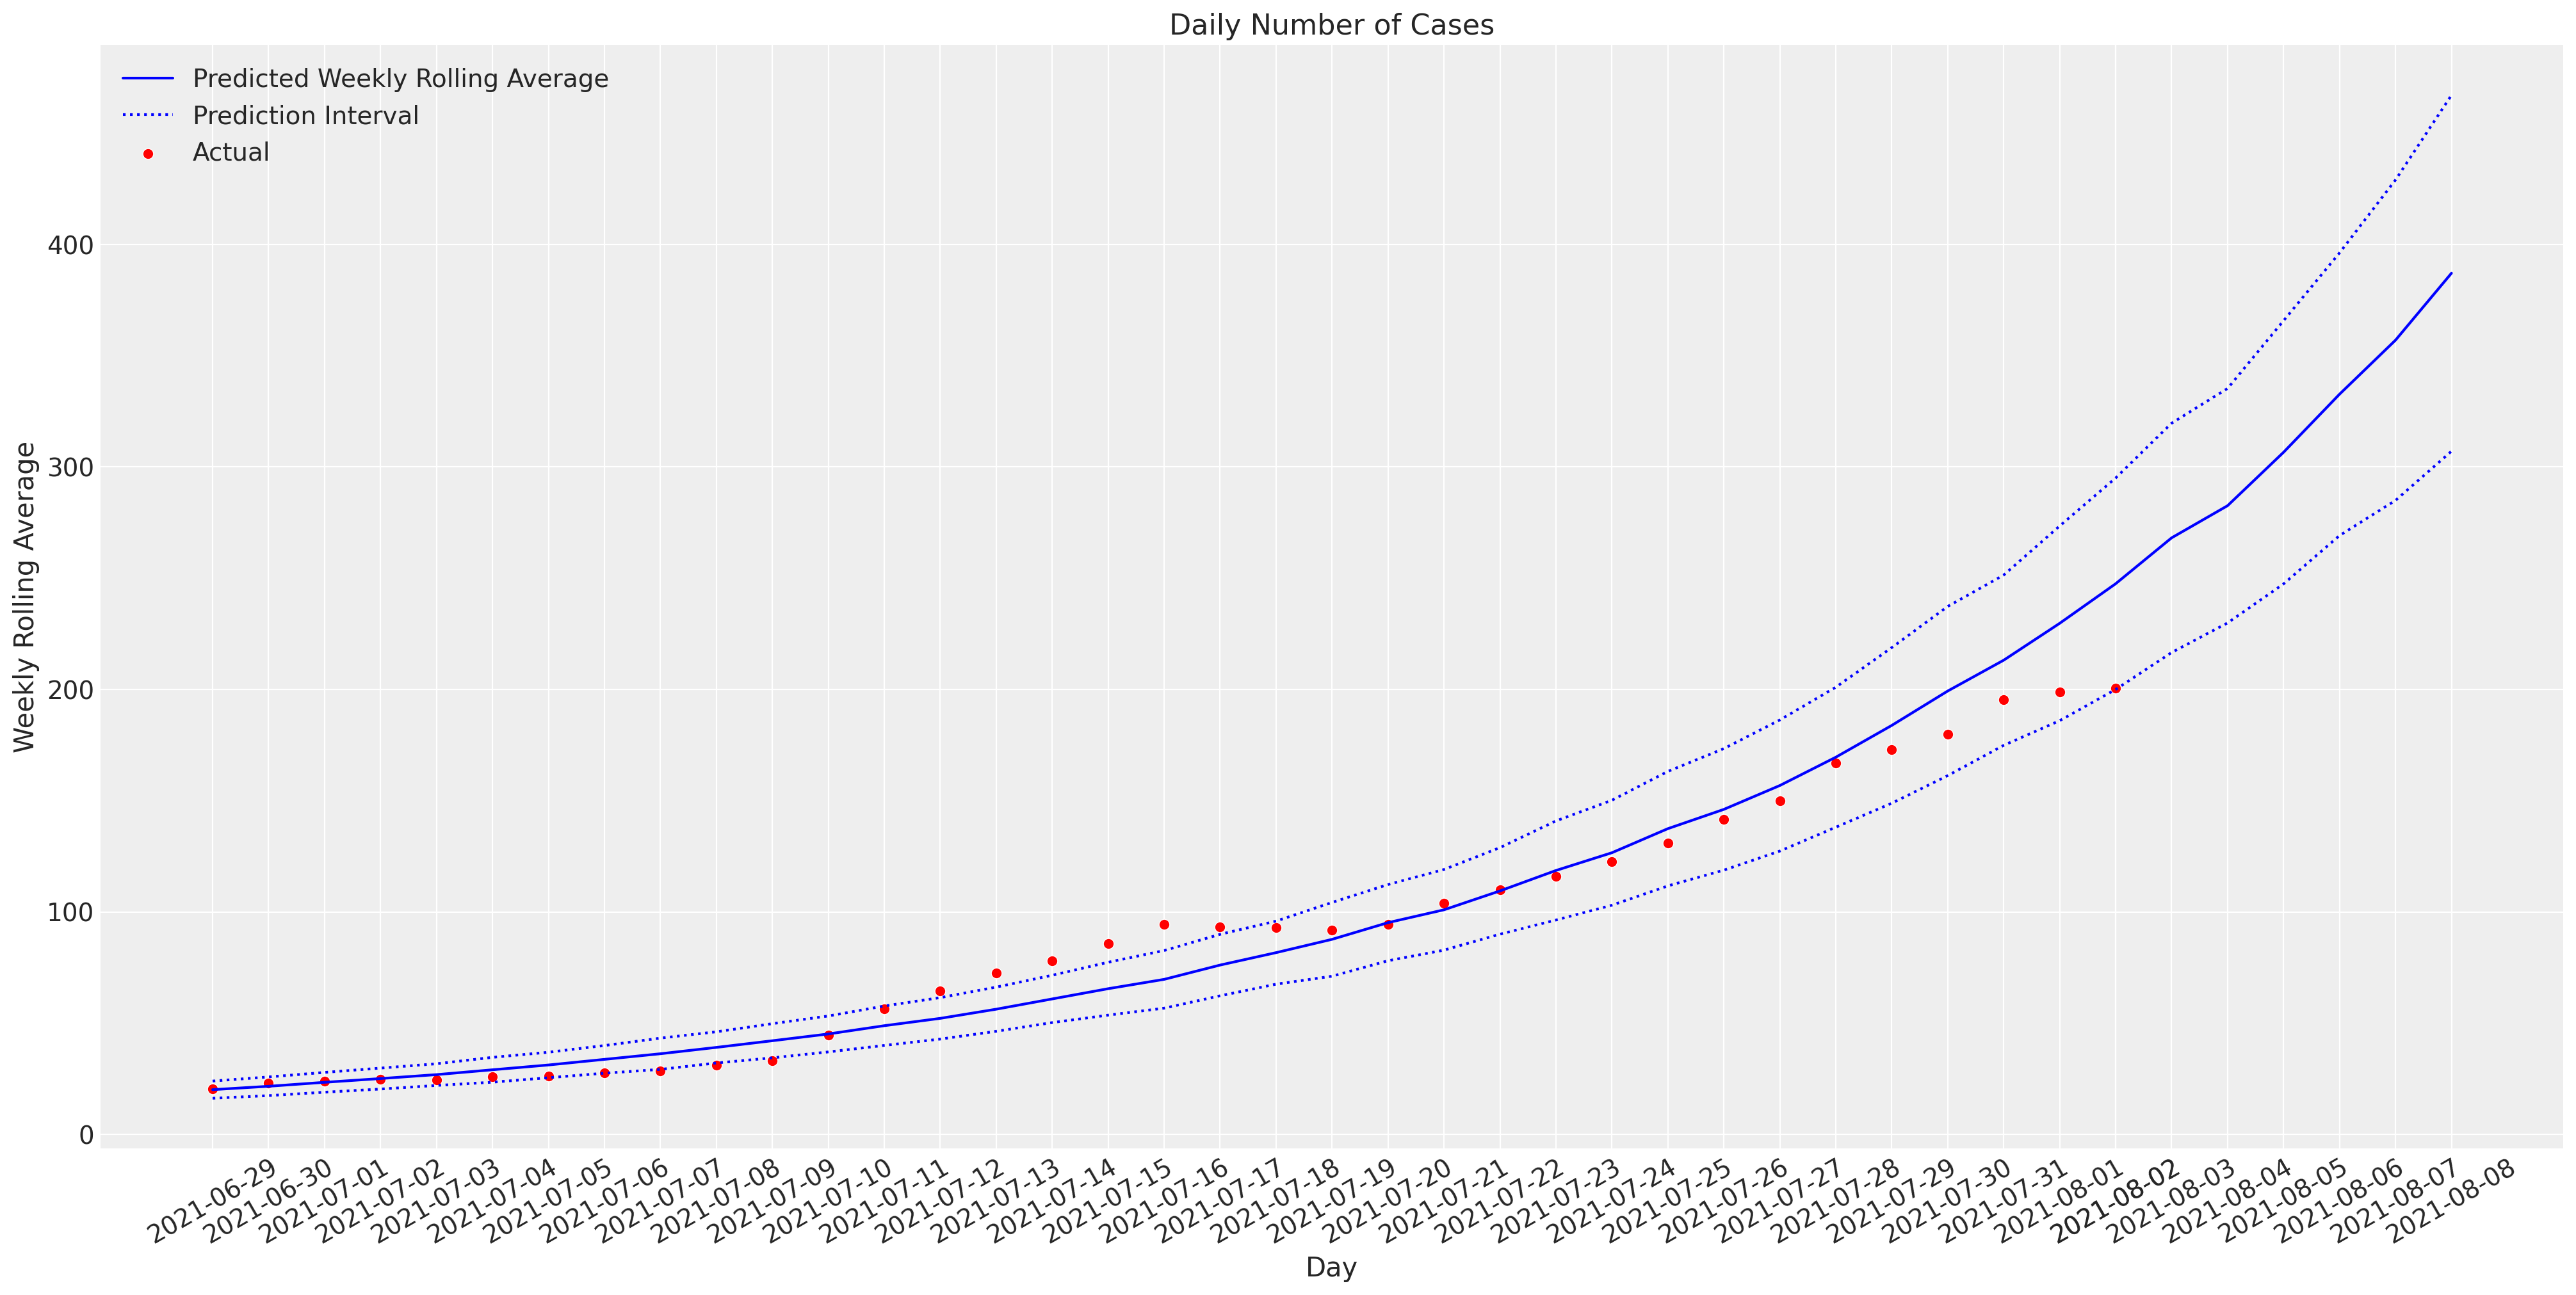

In [23]:
forecast_std = np.std(post_pred_forecast["cases"].T, axis=1)

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=X_forecast, y=np.mean(post_pred_forecast["cases"].T, axis=1), color="b", label="Predicted Weekly Rolling Average", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(post_pred_forecast["cases"].T, axis=1) + forecast_std, color="b", linestyle=":", label="Prediction Interval", ax=ax)
ax = sns.lineplot(x=X_forecast, y=np.mean(post_pred_forecast["cases"].T, axis=1) - forecast_std, color="b", linestyle=":", ax=ax)
ax = sns.scatterplot(x=data.loc[mask, "Epidemiological Days"], y=data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual", ax=ax)

plt.xticks(X_forecast, data_forecast["notification_date"].astype(str), rotation = 30)

ax.set(xlabel="Day", ylabel="Weekly Rolling Average", title="Daily Number of Cases")
ax.legend()
ax.grid(True)

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 04 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.25.0

pymc3     : 3.11.2
seaborn   : 0.11.1
arviz     : 0.11.2
numpy     : 1.19.5
matplotlib: 3.4.2
sys       : 3.9.2 (default, Mar 12 2021, 19:04:51) 
[GCC 8.3.0]
pandas    : 1.3.0

Watermark: 2.2.0

